In [1]:
import gc
import wandb
import pickle
import numpy as np 
import pandas as pd
from tqdm import tqdm 

import torch 
from torch import nn
from torch.utils.data import DataLoader 

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from src.model.utils import load_embeddings
from src.model.data_utils import APNDataset, EMBDataset
from src.model.model import SModel
from src.model.train_utils import train_model
from src.utils import load_code_to_idx

from src.transactions_emb import create_transactions_embeddings
from src.clickstream_emb import create_clickstream_embeddings


In [2]:
# TRAIN_MATCHING_PATH = "./data/train_matching.csv"
# TRANSACTIONS_PATH = "./data/transactions.csv"
# CLICKSTREAM_PATH = "./data/clickstream.csv"

TRAIN_MATCHING_PATH = "/home/glebk/VSProjects/projects/Matching/data/train_matching.csv"
TRANSACTIONS_PATH = "/home/glebk/VSProjects/projects/Matching/data/transactions.csv"
CLICKSTREAM_PATH = "/home/glebk/VSProjects/projects/Matching/data/clickstream.csv"


In [3]:
train_match = pd.read_csv(TRAIN_MATCHING_PATH)
train_match.head()

,bank,rtk
0,178b387813ac4a63a2200274a9e3876e,e19c0f141e9442c5bdb0d5751f6fba1c
1,47cffa46e6b04389ba91a70735d2c3ff,7df3371aabd349e4ac2de8299238627d
2,f73b767cfd72472aa06df9a69e746aaf,b23d62c7e41145a7ad140a4fcfaafefa
3,48da649603734185b98dcea93484dbc7,63ad789541c54463ad54d0a707b3ab8b
4,37304ef19de542ee8fe8a6f050236525,c0e96de5dd594d948a8b9fde9e6980cb


In [4]:
# Separate matched and unmatched:

idx = 14671

train_match_paired = train_match[:idx]
train_match_unpaired = train_match[idx:]

# Sainity check:
assert len(train_match_paired) + len(train_match_unpaired) == len(train_match)
assert train_match_paired.loc[len(train_match_paired) - 1].rtk != "0"
assert train_match_unpaired.iloc[0].rtk == "0"


In [5]:
# K-Fold split:

folds = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, idxs in enumerate(kf.split(train_match_paired)):
    train_index, test_index = idxs
    train = train_match_paired.iloc[train_index]
    test = train_match_paired.iloc[test_index]
    folds[i] = {"train": train.copy(), "test": test.copy()}

In [6]:
# Training config: 

cfg = {
    "wandb_logging": True,
    "fold": 4,
    "test_size": 0.2,
    "n_iters": 7000,
    "n_iters_val": 100,
    "lr": 3e-4,
    "bs": 32,
    "save_best_val": True,
    "checkpoint_path": "./weights",
}

In [7]:
# Logging: 

if cfg["wandb_logging"]:
    wandb.init(project="matching", entity="glebk")
    wandb.config = cfg

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: glebk (use `wandb login --relogin` to force relogin)


In [8]:
# Loading cat_id to idx mapping:

mcc_code_to_idx, cat_code_to_idx = load_code_to_idx(
    "./submission/mcc_code_to_idx.pickle",
    "./submission/cat_code_to_idx.pickle",
)


In [32]:
# Load raw transactions:

transactions = pd.read_csv(TRANSACTIONS_PATH)
print(transactions.shape)

# Remove transactions with mcc == -1:
transactions = transactions[transactions.mcc_code != -1]
print(transactions.shape)

transactions.head()


(19821910, 5)
(19198619, 5)


,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,000932580e404dafbecd5916d4640938,5411,48,-361.07230,2020-08-03 08:05:23
1,000932580e404dafbecd5916d4640938,5499,48,-137.31398,2020-08-05 01:27:40
2,000932580e404dafbecd5916d4640938,5499,48,-138.84981,2020-08-05 03:28:11
3,000932580e404dafbecd5916d4640938,4829,48,-309.47653,2020-08-06 00:36:29
4,000932580e404dafbecd5916d4640938,5411,48,-133.47370,2020-08-09 00:30:13


In [10]:
# Transform transactions to feature vectors:

bank_trans_emb = create_transactions_embeddings(transactions, mcc_code_to_idx)
bank_trans_emb.head()


,user_id,0,1,2,3,4,5,6,7,8,...,375,376,377,378,379,380,381,382,383,384
0,000932580e404dafbecd5916d4640938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,0009e36b42cb4caeb928a1e596819495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,000b29acb6bd44f99473c1be5ca28f3c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
3,000c5327d99941fe934169838c65b92c,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,0.0,0.0
4,000e0d54d7c945ebb8f6f855972e8396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Load raw clickstream:

clickstream = pd.read_csv(CLICKSTREAM_PATH)
clickstream.head()


,user_id,cat_id,timestamp,new_uid
0,000143baebad4467a23b98c918ccda19,165,2021-01-30 20:08:12,1873448
1,000143baebad4467a23b98c918ccda19,165,2021-01-31 20:06:29,1873448
2,000143baebad4467a23b98c918ccda19,308,2021-01-31 20:12:00,1873448
3,000143baebad4467a23b98c918ccda19,931,2021-01-31 22:12:00,1873448
4,000143baebad4467a23b98c918ccda19,931,2021-02-01 16:57:00,1873448


In [12]:
# Transform clickstream to feature vectors:

rtk_emb = create_clickstream_embeddings(clickstream, cat_code_to_idx)
rtk_emb.head()

,user_id,0,1,2,3,4,5,6,7,8,...,392,393,394,395,396,397,398,399,400,401
0,000143baebad4467a23b98c918ccda19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000a8d3cdef3455d990e97730a2cef43,52.0,0.0,0.0,0.0,0.0,233.0,0.0,1.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000c399352314e759041dc1651fe6980,5.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,278.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000eb2d39f4f4df0afd630c4f11ca049,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000fc5be9e974980a1c9728f4866db11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Train val split:

train_df = folds[cfg["fold"]]["train"]
val_df = folds[cfg["fold"]]["test"]

train_dataset = APNDataset(train_df, bank_trans_emb, rtk_emb)
val_dataset = APNDataset(val_df, bank_trans_emb, rtk_emb)

print('Train size: ', len(train_dataset))
print('Val size: ', len(val_dataset))

Train size:  11737
Val size:  2934


In [14]:
train_loader = DataLoader(train_dataset, batch_size=cfg["bs"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=cfg["bs"], shuffle=False)

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [16]:
model = SModel().to(device)

In [17]:
criterion = nn.TripletMarginWithDistanceLoss(
    distance_function=lambda x, y: 1.0 - nn.functional.cosine_similarity(x, y)
)

optimizer = torch.optim.Adam(model.parameters(), lr=cfg["lr"])
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=1000, gamma=0.9, verbose=True
)


Adjusting learning rate of group 0 to 3.0000e-04.


In [ ]:
train_model(
    model, train_loader, val_loader, criterion, device, optimizer, scheduler, cfg
)


# Dist

In [19]:
from scipy.spatial import distance
from src.model.utils import load_model
import matplotlib.pyplot as plt

In [25]:
train_loader = DataLoader(train_dataset, 1, shuffle=False)
val_loader = DataLoader(val_dataset, 1, shuffle=False)

train_df = folds[1]["train"]
val_df = folds[1]["test"]

train_dataset = APNDataset(train_df, bank_trans_emb, rtk_emb)
val_dataset = APNDataset(val_df, bank_trans_emb, rtk_emb)

In [26]:
model_weights = "./weights/SModel_0.774_fold_1.pth"
model = load_model(model_weights, model, device)

In [27]:
def get_embs(model, data, device):

    A_emb = model(data["anchor"].to(device), "vtb")
    P_emb = model(data["positive"].to(device), "rtk")
    N_emb = model(data["negative"].to(device), "rtk")

    return A_emb, P_emb, N_emb

In [28]:
# Threshold distance extimation:

def calc_distances(v1, v2):
    euclid = distance.euclidean(v1, v2)
    cosine = distance.cosine(v1, v2)
    return euclid, cosine

In [29]:
pos_dists_eucl, neg_dists_eucl = [], []
pos_dists_cos, neg_dists_cos = [], []


emb_iter = iter(train_loader)
for i in tqdm(range(len(emb_iter))):
    data = next(emb_iter)
    A_emb, P_emb, N_emb = get_embs(model, data, device)

    A_emb = A_emb.squeeze(0).detach().cpu().numpy()
    P_emb = P_emb.squeeze(0).detach().cpu().numpy()
    N_emb = N_emb.squeeze(0).detach().cpu().numpy()

    p_dist_eucl, p_dist_cos = calc_distances(A_emb, P_emb)
    n_dist_eucl, n_dist_cos = calc_distances(A_emb, N_emb)

    pos_dists_eucl.append(p_dist_eucl)
    neg_dists_eucl.append(n_dist_eucl)

    pos_dists_cos.append(p_dist_cos)
    neg_dists_cos.append(n_dist_cos)


100%|██████████| 11737/11737 [00:52<00:00, 221.67it/s]


In [30]:
pos_dists_eucl = np.array(pos_dists_eucl)
neg_dists_eucl = np.array(neg_dists_eucl)

pos_dists_cos = np.array(pos_dists_cos)
neg_dists_cos = np.array(neg_dists_cos)


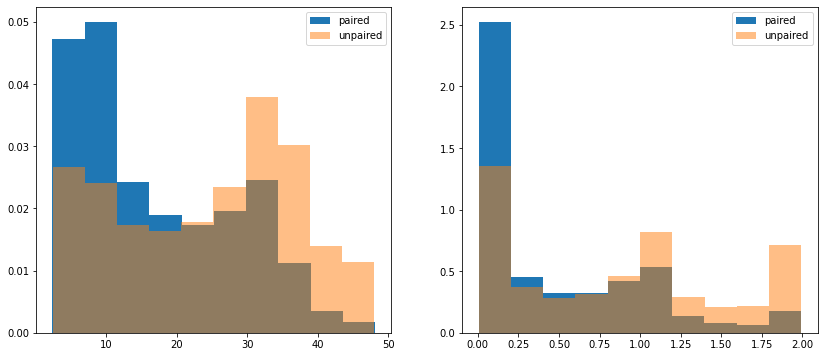

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].hist(pos_dists_eucl, density=True, label="paired")
ax[0].hist(neg_dists_eucl, density=True, label="unpaired", alpha=0.5)

ax[1].hist(pos_dists_cos, density=True, label="paired")
ax[1].hist(neg_dists_cos, density=True, label="unpaired", alpha=0.5)

ax[0].legend()
ax[1].legend()
